# Make MasterBias CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 23th 2017

### This notebook computes the Master Bias
-----------------------------------------


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [4]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [5]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [6]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [7]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [8]:
from IPython.display import Image, display

In [9]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [10]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [11]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [12]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [13]:
outputfile="MasterBias_CTIO_20170118.fits"

## Location of corrected images
----------------------------------

In [14]:
rootpath_rawimage="./trim_images"
object_name='Bias'

In [15]:
dirlist_all=os.listdir(rootpath_rawimage) 

In [16]:
#if '.DS_Store' in dirlist_all:
#    dirlist_all.remove('.DS_Store')
dirlist=[]
dirlist.append(rootpath_rawimage)
dirlist_all=np.array(dirlist)

In [17]:
print dirlist_all

['./trim_images']


In [18]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [19]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image       
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search('^trim_20170118_([0-9]+).fits$',filename):  #example of filename filter
                    str_index=re.findall('^trim_20170118_([0-9]+).fits$',filename)
                    count=count+1
                    index=int(str_index[0])
                    indexes_files.append(index)         
                    shortfilename=dir_leaf+'/'+filename
                    filelist_fitsimages.append(shortfilename)
                    
    return

In [20]:
MakeFileList()   # Make the list

In [21]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [22]:
print len(indexes_files)

10


In [23]:
print len(filelist_fitsimages)

10


In [24]:
print indexes_files

[215 216 217 218 219 220 221 222 223 224]


In [25]:
len(indexes_files)

10

In [26]:
filelist_fitsimages

array(['./trim_images/trim_20170118_215.fits',
       './trim_images/trim_20170118_216.fits',
       './trim_images/trim_20170118_217.fits',
       './trim_images/trim_20170118_218.fits',
       './trim_images/trim_20170118_219.fits',
       './trim_images/trim_20170118_220.fits',
       './trim_images/trim_20170118_221.fits',
       './trim_images/trim_20170118_222.fits',
       './trim_images/trim_20170118_223.fits',
       './trim_images/trim_20170118_224.fits'], 
      dtype='|S36')

In [27]:
len(filelist_fitsimages)

10

In [28]:
#sorted_dates=np.argsort(filelist_fitsimages)

In [29]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [30]:
sorted_indexes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
#print sorted_dates

In [32]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8 9]


In [33]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [34]:
#sorted_numbers= [indexes_files[index] for index in sorted_indexes]
sorted_numbers=indexes_files[sorted_indexes]

In [35]:
sorted_numbers

array([215, 216, 217, 218, 219, 220, 221, 222, 223, 224])

In [36]:
sorted_files

array(['./trim_images/trim_20170118_215.fits',
       './trim_images/trim_20170118_216.fits',
       './trim_images/trim_20170118_217.fits',
       './trim_images/trim_20170118_218.fits',
       './trim_images/trim_20170118_219.fits',
       './trim_images/trim_20170118_220.fits',
       './trim_images/trim_20170118_221.fits',
       './trim_images/trim_20170118_222.fits',
       './trim_images/trim_20170118_223.fits',
       './trim_images/trim_20170118_224.fits'], 
      dtype='|S36')

## Build full filename
----------------------------

In [37]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(rootpath_rawimage,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [38]:
sorted_filenames=np.array(sorted_filenames)

In [39]:
sorted_filenames

array(['./trim_images/trim_20170118_215.fits',
       './trim_images/trim_20170118_216.fits',
       './trim_images/trim_20170118_217.fits',
       './trim_images/trim_20170118_218.fits',
       './trim_images/trim_20170118_219.fits',
       './trim_images/trim_20170118_220.fits',
       './trim_images/trim_20170118_221.fits',
       './trim_images/trim_20170118_222.fits',
       './trim_images/trim_20170118_223.fits',
       './trim_images/trim_20170118_224.fits'], 
      dtype='|S36')

## Acces to data of  images
----------------------------------

In [40]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [41]:
def BuildRawImages():
    """
    BuildRawImages
    ===============
    """

    global all_dates
    global all_airmass
    global all_images
    global all_titles
    global all_header
    global all_img 
    global sorted_filenames

    for idx,file in np.ndenumerate(sorted_filenames):   
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        num=sorted_numbers[idx[0]]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        hdu_list.close()

In [42]:
BuildRawImages()

## Show images
-----------------------

In [43]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    global all_images
    global all_titles
    global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1

    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=50)
        axarr[iy,ix].set_title(all_titles[index])
    title='Raw images of '.format(object_name)
    plt.suptitle(title,size=16)        

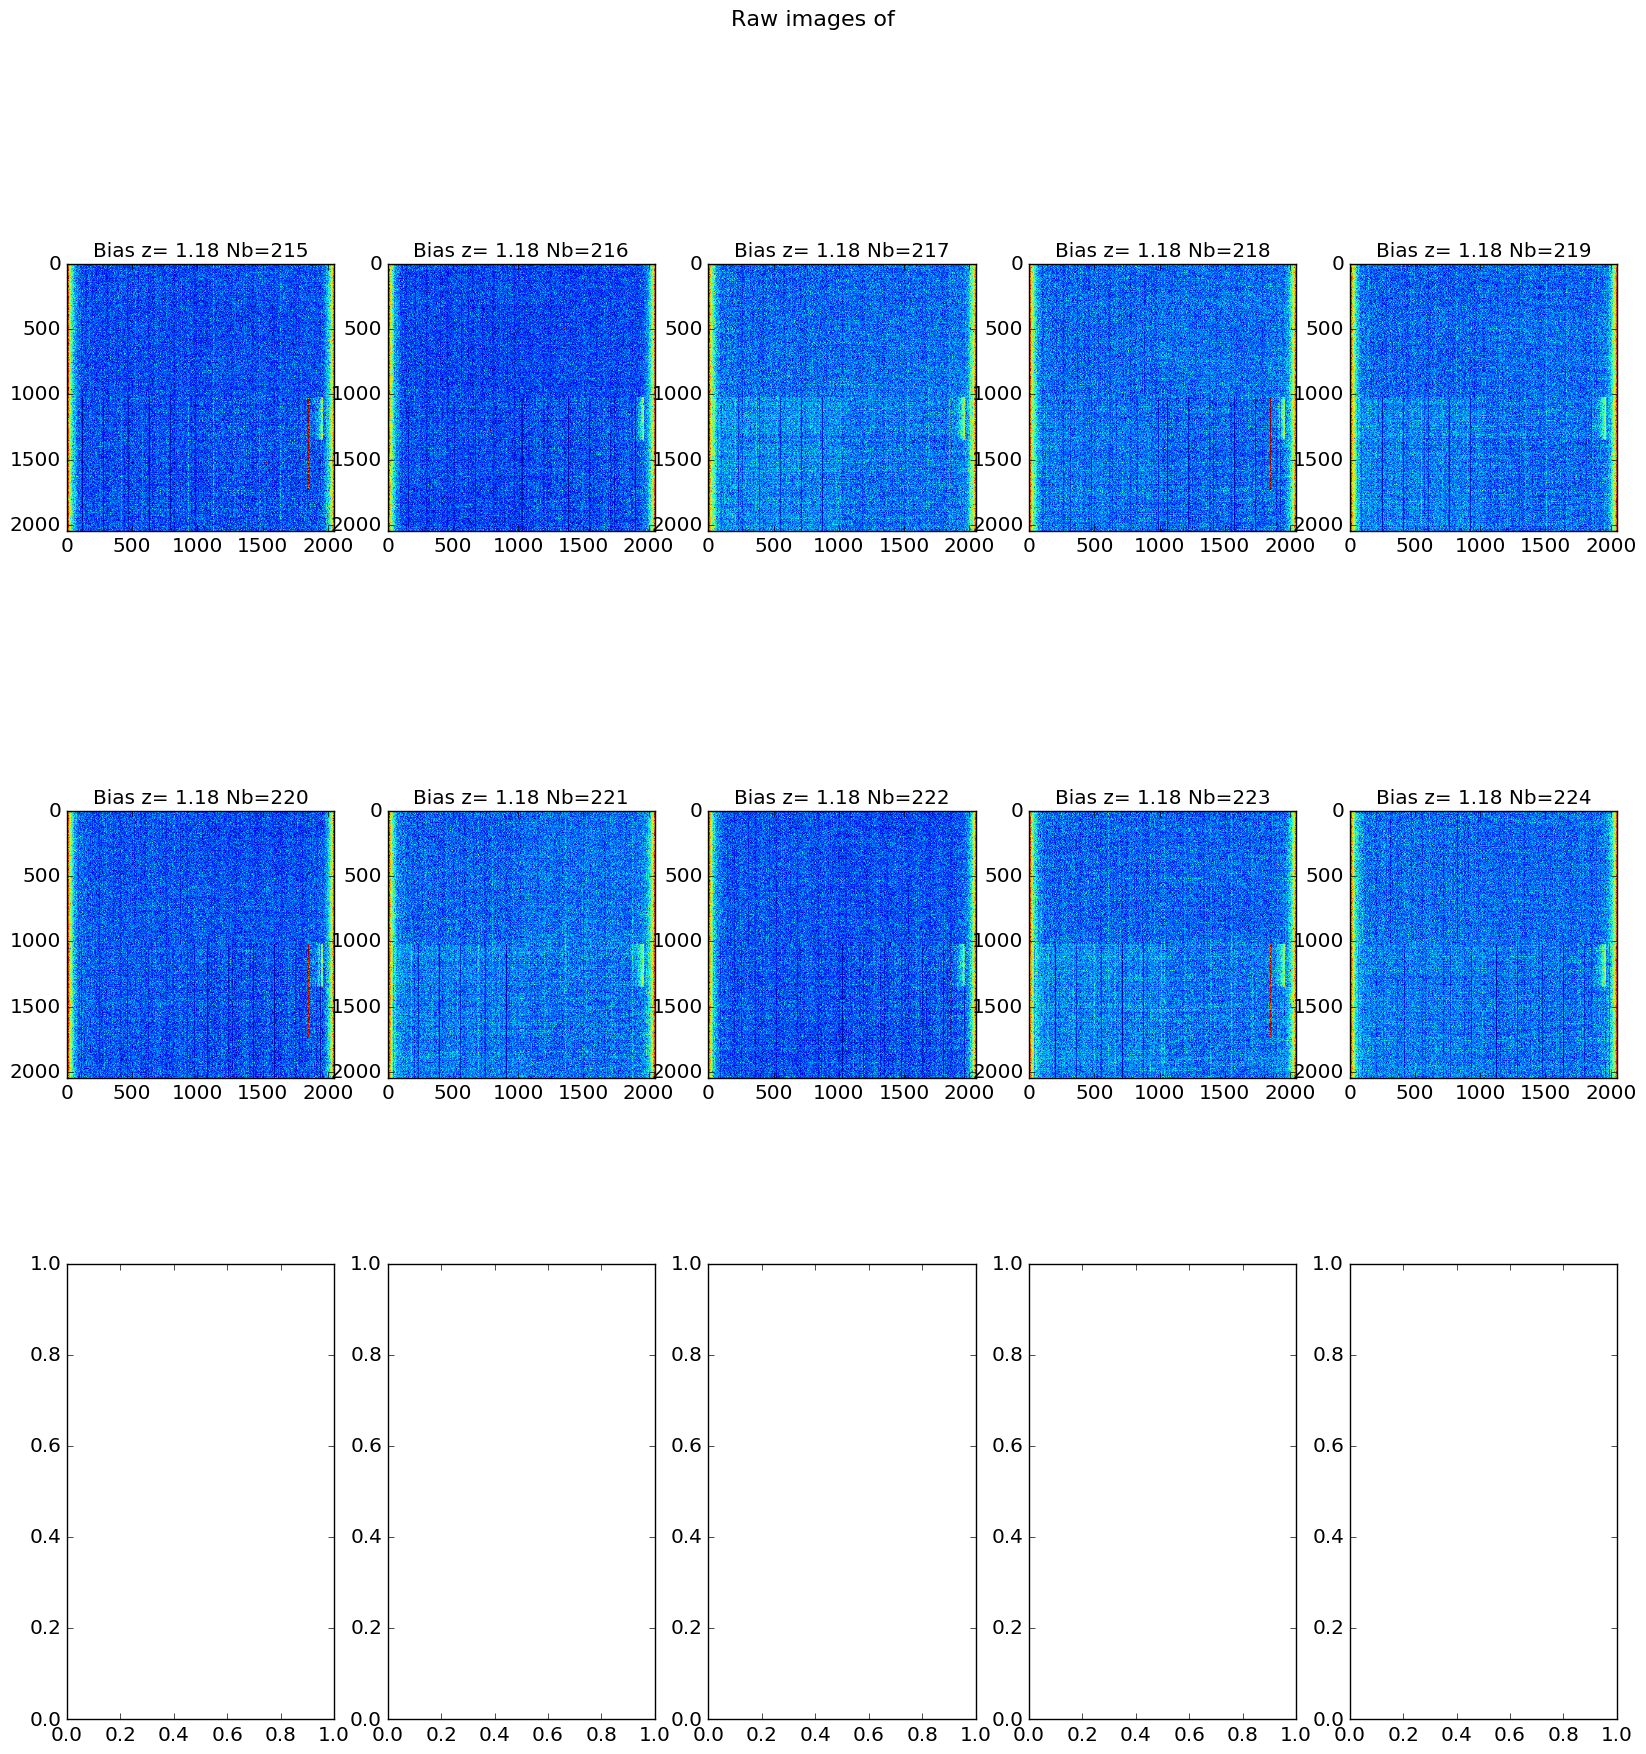

In [44]:
ShowRawImages()

## Show histograms
===========================

In [45]:
def ShowHistograms():
    """
    ShowHistograms
    ==============
    """
    global all_images
    global all_titles
    global object_name


    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        image_flat=all_images[index].flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=100,range=(-50,200),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e10)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
    title='histo of images '.format(object_name)
    plt.suptitle(title,size=16)        

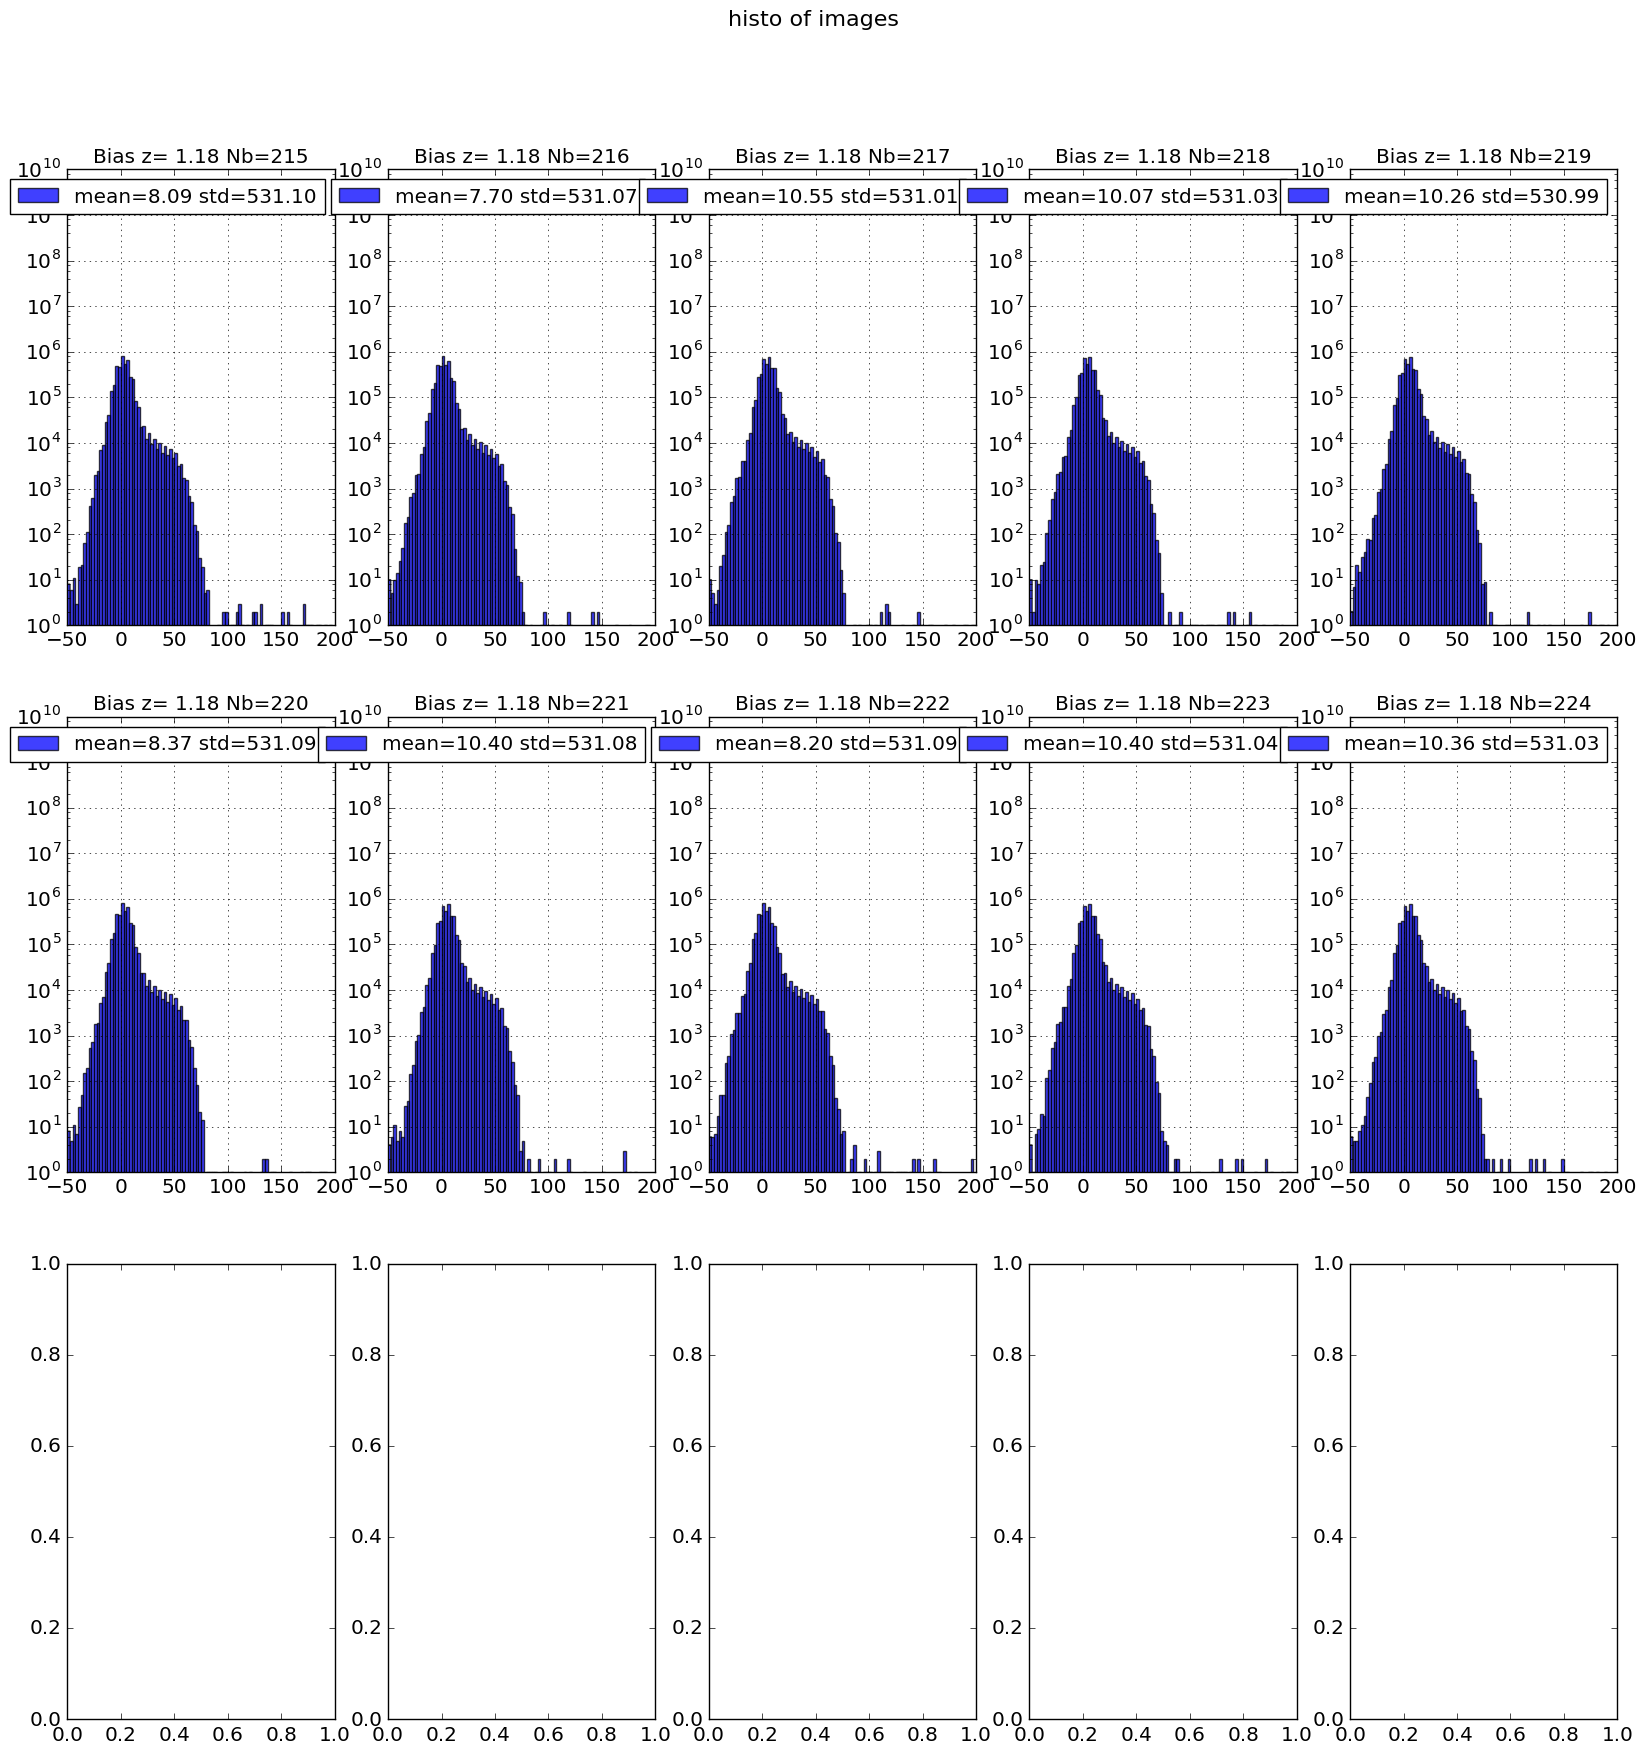

In [46]:
ShowHistograms()

## Transfer the image in CCDData
====================================

In [47]:
NBIMAGES=len(all_images)
all_bias = []
for index in np.arange(0,NBIMAGES):
    ccd=ccdproc.CCDData(all_images[index],unit='adu')
    all_bias.append(ccd)

## Make Master Bias
============================

In [48]:
biases = ccdproc.Combiner(all_bias)

In [49]:
#master_bias = biases.average_combine()
master_bias = biases.median_combine()

## Result on Master Bias
===============================

In [50]:
bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

In [51]:
print bias_min, bias_max, bias_mean, bias_std

-232.0 60284.0 9.53611528873 530.997311982


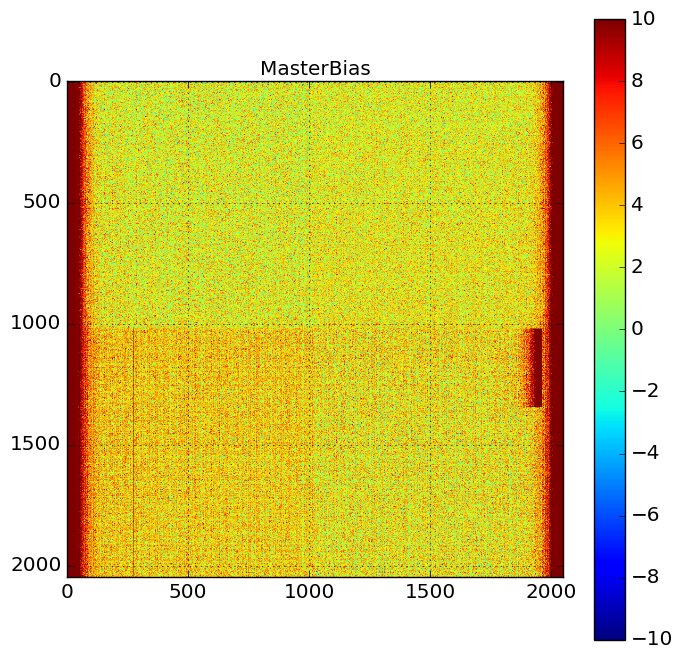

In [52]:
plt.figure(figsize=(8, 8))
#plt.imshow(master_bias, vmax=bias_mean + bias_std, vmin=bias_mean - bias_std)
plt.imshow(master_bias, vmax=10, vmin=- 10)
plt.grid(True)
plt.colorbar()
plt.title('MasterBias')

In [53]:
flatten_bias=master_bias.data.flatten()

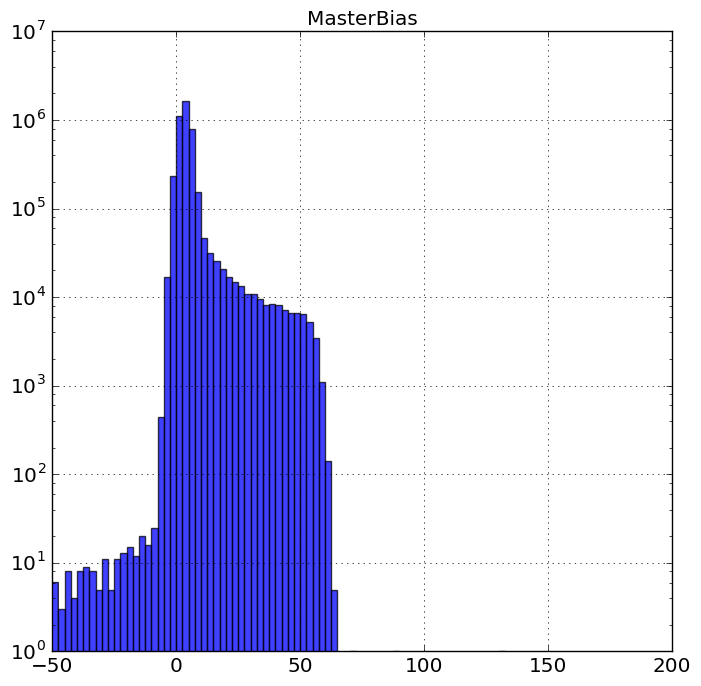

In [54]:
plt.hist(flatten_bias,bins=100,range=(-50,200),facecolor='blue', alpha=0.75);
plt.yscale('log')
plt.grid(True)
plt.title('MasterBias')

## Save the Master Bias
----------------------------------------------------------

In [55]:
prihdu = fits.PrimaryHDU(header=all_header[0],data=master_bias.data)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfile,clobber=True)